### About this project

#### Cookie cats

__[Cookie cats](https://www.facebook.com/cookiecatsgame)__ is a hugely popular mobile puzzle game developed by __[Tactile Entertainment](https://tactilegames.com/)__. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this project I am going to analyze an AB-test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, I am going to look at the impact on player retention.

### Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cookie_cats.csv")

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

**userid** - a unique number that identifies each player. <br>
**version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40). <br>
**sum_gamerounds** - the number of game rounds played by the player during the first 14 days after install. <br>
**retention_1** - did the player come back and play 1 day after installing? <br>
**retention_7** - did the player come back and play 7 days after installing? <br>

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [3]:
#  Counting the number of players in each AB group.

df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

There are roughly the same number of players in each AB group.

### Distribution of game rounds

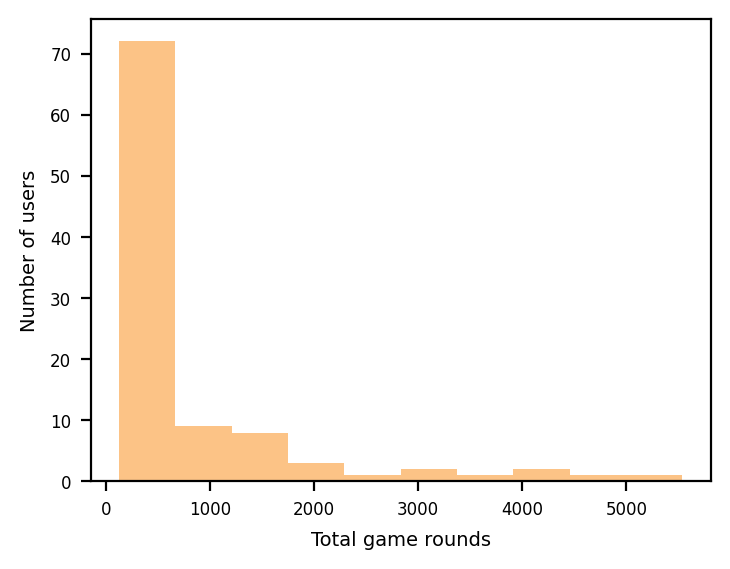

In [4]:
#  Counting the number of players for each number of gamerounds 

plot_df = df.groupby('sum_gamerounds')['userid'].count()


#  Plotting the distribution of players that played 0 to 100 game rounds

ax, fig = plt.subplots(dpi=200, figsize=(4, 3))

ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid', kind='hist', color='#fcc386')
ax.set_xlabel("Total game rounds", fontsize=7)
ax.set_ylabel("Number of users", fontsize=7)

ax.tick_params(axis='both', labelsize=6)

plt.show()

### Overall 1-day retention

In the plot above it can be seen that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked.

What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: the percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [5]:
#  The % of users that came back the day after they installed the game

df['retention_1'].mean()

0.4452095044850259

A little less than half of the players come back one day after installing the game.

In [6]:
#  Calculating 1-day retention for each AB-group

df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact.

But, should we be confident in this difference?

There are a couple of ways to get at the certainty of these retention numbers. Here I will use bootstrapping: I will repeatedly re-sample the dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give an indication of how uncertain the retention numbers are.

#### Bootstrap analysis for 1-day retention

In [7]:
#  Creating a list with bootstrapped means for each AB-group

boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
    
#  Transforming the list to a DataFrame

boot_1d = pd.DataFrame(boot_1d)

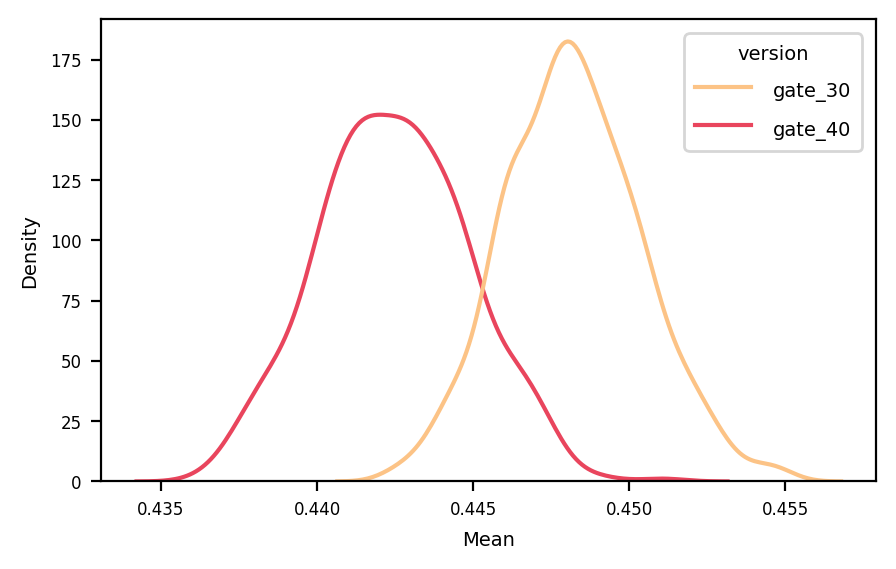

In [8]:
#  A Kernel Density Estimate plot of the bootstrap distributions

fig, ax = plt.subplots(dpi=200, figsize=(5, 3))

colours = ['#fcc386', '#e9455d']

sns.kdeplot(data=boot_1d, common_norm=False, ax=ax, palette=colours)

ax.tick_params(axis='both', labelsize=6)

ax.set_ylabel("Density", fontsize=7)
ax.set_xlabel("Mean", fontsize=7)
plt.setp(ax.get_legend().get_texts(), fontsize='7') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='7') # for legend title

plt.show()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Next, I will zoom in on the difference in 1-day retention.

(Note that in this notebook I have limited the number of bootstrap replication to 500 to keep the calculations quick. In "production" this would likely be increased to a much larger number, say, 10 000.)

#### Zooming in on the difference

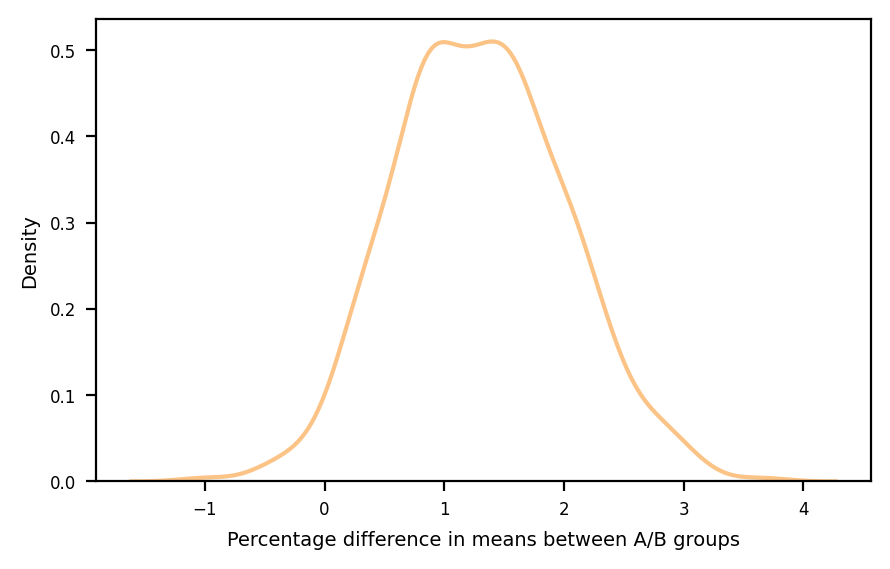

In [9]:
#  Adding a column with the % difference between the two AB-groups

boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100


#  Plotting the bootstrap % difference

fig, ax = plt.subplots(dpi=200, figsize=(5, 3))

sns.kdeplot(data=boot_1d['diff'], common_norm=False, ax=ax, color='#fcc386')

ax.tick_params(axis='both', labelsize=6)

ax.set_ylabel("Density", fontsize=7)
ax.set_xlabel("Percentage difference in means between A/B groups", fontsize=7)

plt.show()

From this chart, it can be seen that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%?

#### Probability of a difference

In [10]:
#  Calculating the probability that 1-day retention is greater when the gate is at level 30

prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)


#  Pretty printing the probability

'{:.1%}'.format(prob)

'97.8%'

### 7 day retention by AB-group

The bootstrap analysis shows that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: what percentage of the people that installed the game also showed up a week later to play the game again.

In [11]:
#  Calculating 7-day retention for both AB-groups

df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Like with 1-day retention, the 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. 

In addition, the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

#### Bootstrap analysis for 7-day retention

In [12]:
#  Creating a list with bootstrapped means for each AB-group

boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
    
#  Transforming the list to a DataFrame

boot_7d = pd.DataFrame(boot_7d)


#  Adding a column with the % difference between the two AB-groups

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

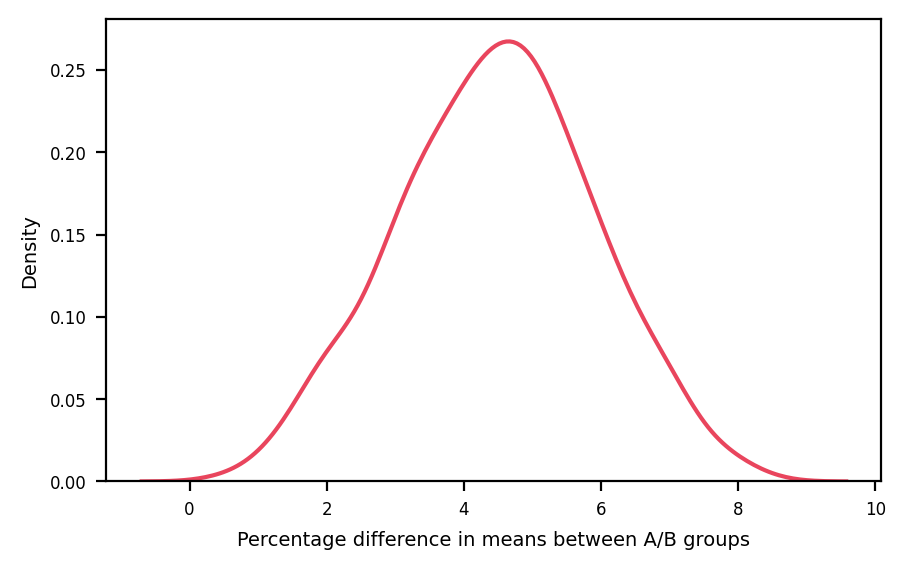

In [13]:
#  Plotting the bootstrap % difference

fig, ax = plt.subplots(dpi=200, figsize=(5, 3))

sns.kdeplot(data=boot_7d['diff'], common_norm=False, ax=ax, color='#e9455d')

ax.tick_params(axis='both', labelsize=6)

ax.set_ylabel("Density", fontsize=7)
ax.set_xlabel("Percentage difference in means between A/B groups", fontsize=7)

plt.show()

#### Probability of a difference

In [14]:
#  Calculating the probability that 7-day retention is greater when the gate is at level 30

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)


#  Pretty printing the probability

'{:.1%}'.format(prob)

'100.0%'

### Conclusion

The bootstrap result shows that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: in order to keep retention high — both 1-day and 7-day retention — the gate should not be moved from level 30 to level 40. 

Other metrics could be looked at as well, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If player base is not retained, it doesn't matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: the later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of **hedonic adaptation** can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.